# Text Mining for Hypothesis Generation - Improvements and Validation
Group Members: Raya Kavosh, Ian Carrasco, Braden Riggs, Ron Hasson, Cameron Goharbin, Justin Yang, Mor Greenbaum, Maxwell Chen

(FOR PUBLIC RELEASE)

## Overview 
>&emsp; In this work, we aim to develop new approaches to automated hypothesis generation utilizing statistical properties of existing neuroscience literature. Particularly, we try to extend upon the approach presented in Voytek, et al. (2012)  by presenting a hypothesis-first algorithm for computing hypothesis "attractiveness" which identifies qualitatively better hypotheses. Using our proposed algorithm to generate hypotheses using PubMed data collected from the years 1700 to 2000, we then then validate said hypotheses on data from 2000 to present. This validation is used as a benchmark to quantify the strength of our proposed algorithm, and demonstrate the potential to generate future hypotheses to be pursued.

## Research Question
>##### Can we generate valid hypotheses and assess their prevalance across time by utilizing a percent change measure gathered from large-scale, time-based analysis of neuroscience literature?

## Background & Prior Work
>&emsp; With neuroscientific research being published at an increasingly high volume, there is a growing need to create automated techniques to perform meta-analysis of said research. This need grows out of individual researchers not having enough bandwidth to stay on top of the growth of the field at large, potentially missing novel interactions between topics that can advance current research.

>&emsp;In recent years, approaches have been proposed to solve a problem known as *automated hypothesis generation*, which, at a high level, attempts to find said missing interactions by performing large scale analysis across field-wide literature databases (i.e. PubMed). Voytek, et al.[1] proposed an algorithm based upon finding terms in the literature that show a large amount of shared publications between two child terms and a parent term with a considerably less amount of publications between the two child terms. More recent work by Wilson et al. [2] and Sybrant et al. [3], utilized natural language processing (NLP) approaches to parse abstracts to find significant interactions between cancer genes and various biomedical research topics, respectively.
Additionally, other approaches have proposed deep learning based solutions operating on graph representations of term interactions as seen in [4]. <br/>

>&emsp; In our project our goals are two-fold. Firstly, to develop a new algorithm for identifying and ranking candidate hypotheses accurately. Secondly, to propose a framework and dataset that allows candidate hypotheses to be validated by their characteristics in future time periods. Particularly, we use term co-occurence aggregated from the years 1700-2000 to generate hypotheses which we then validate using co-occurence data from 2000-present, by computing percent change between the two periods.

### Data Collection 
>&emsp;We based our data collection on the same 591 neuroscience terms that were analyzed in Voytek[1], to provide a reasonable benchmark to compare our models against. Using these terms, we utilized the NCBI E-Utils to fetch intersection and union counts for the ~174k hypotheses (term-pairs) for the years 1700-2000 and 2000-2021 that were based on a term's presence in either the title and/or abstract of a given paper. For example, given a term pair (t1 , t2), we would query all papers in a given time period whose titles and/or abstracts contain both t1 AND t2, and compute the sum of t1 NOT t2 and t2 NOT t1. From here, we constructed three matrices where the entries in each represented the intersection, union, and intersection over union (connectivity).

>&emsp;In order to make the fetching of multiple time periods reasonable we designed a scraper which we call, MicroLisc (*full source: ./data_collection/microlisc.py*), that utilizes multi-threading to make requests with a throughput of ~200 requests/sec. Additionally, we were able to vastly  reduce the amount of requests via caching since |X NOT Y| + |Y NOT X| = |X| + |Y|, when there are no intersections between X AND Y. Hence, by checking for intersection first, we could then retrieve the cardinalities of X and Y from a cache, leaving most hypotheses only requiring only 1 http request (not intersecting), and at max 3 http requests (if intersecting). The combination of these two optimizations allowed us to collect the complete set of hypothesis data for an entire time period in under 1.5 hours. We believe this decrease in data collection time will facilitate further analysis of multiple time periods.

### Hypothesis
We believe that our proposed algorithm can provide greater utility in generating hypotheses that are predictive of future neuroscience trends. 

We think this will be the outcome because our algorithm produces hypotheses for 

## Data Analysis

In [101]:
import os # Filesystem Interaction
import pandas as pd # Dataframe Processing
import numpy as np # Numerical Computation
import time # Benchmarking
import argparse # Command Line Argument Parsing
from data_collection.microlisc import MicroLisc # Our Scraper
from data_collection.utils import check_symmetric, percentage_change
from itertools import combinations
from scipy.stats import spearmanr
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import itertools
import ipywidgets as widgets
from IPython.display import display, HTML, clear_output
import data_collection.microlisc as microlisc
import importlib
from numpy import genfromtxt
import plotly.express as px
from IPython.display import Image
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

### Data Wrangling
We configure our data directories and nest terms with their synonyms which produces a list of 591 terms(including synonyms). We then initializes our scraper(data_collection/microlisc.py) with this specific term set, and run a job with a specified config, which outlines the two time periods in which to gather the conjunction, intersection, and connectivity counts. (See below)

#### Configuration and Brain Term Initialization

In [98]:
# Load the 591 terms from the original analysis
proj_dir = os.getcwd()
data_dir = os.path.join(proj_dir,'./data')
header = ['term', 'synonyms', 'domain']
df = pd.read_csv(os.path.join(data_dir, 'brain_terms.csv'), names= header)
term_types = df.domain.unique()
mapping = dict(df[['term','domain']].values)
mapping_lower = {k.lower(): v for k, v in mapping.items()}


# Nest all unique terms from the terms dataframe
lis = [[f'"{j}"' for j in list(set(list(df[df.term == i]['synonyms']) \
                                 + list(df[df.term == i]['term'])))] for i in df.term.unique()]

assert len(lis) == 591

In [6]:
def fetch_data(**kwargs):
    '''
    Takes a configuration object (below) and fetches the relevant data
    
    '''
    # Instantiate MicroLisc
    ml = MicroLisc(terms=kwargs['terms'])

    # Run The Scraping Job
    print(f'Fetching from {kwargs["start"]} to {kwargs["end"]}')
    t_start = time.time()
    conj, disj = ml.run_collection(num_of_pairs=-1, date_range=(kwargs['start'], kwargs['end']))
    t_end = (time.time() - t_start)

    # Clean and Process the Conjunction and Disjunction Matrices
    d_idxs = np.diag_indices(conj.shape[0])
    conj[d_idxs] = 0
    disj[d_idxs] = 0

    # Turn left triangular matrix into symmetrical matrix since (t1, t2) <-> (t2, t1)
    conj += conj.T
    disj += disj.T
    
    # Build Connectivity (IoU) Matrix
    np.seterr(divide='ignore', invalid='ignore')
    conn = conj_pre/disj_pre
    conn[d_idxs] = 1
    conn = np.nan_to_num(conn)

    # Make Sure Matrices Are Symmetrical
    assert check_symmetric(conn) == True
    assert check_symmetric(conj) == True
    assert check_symmetric(disj) == True
    
    
    print(f'Total Time: {end:0.3f}s')
    print('Saving Matrices...')
    
    # Write matrices to files
    np.savetxt(f'./conj_{out_prefix}.csv', conj, delimiter=',')
    np.savetxt(f'./disj_{out_prefix}.csv', disj, delimiter=',')
    np.savetxt(f'./conn_{out_prefix}.csv', conn, delimiter=',')

#### Skip These Cells to Use Already Downloaded Data

In [7]:
'''
Configuration Fields:
    start: The start date in YYYY/MM/DD format
    end: The end date in YYYY/MM/DD format
    out_prefix: Prefix for output files
'''

# Initialize Configuration for Scraping
CONFIG_PRE = {'start':'1700/01/01', 
              'end':'1999/12/31', 
              'out_prefix':'pre_2000',
              'terms': lis}

CONFIG_POST = {'start':'2000/01/01', 
               'end':'2021/03/08', 
               'out_prefix':'post_2000',
               'terms': lis}

In [ ]:
fetch_data(**CONFIG_PRE)

In [ ]:
fetch_data(**CONFIG_POST)

### Data Visualization

In [3]:
# Load pre- and post- 2000 dataframes
d_pre = genfromtxt('./new_data/disj_pre.csv', delimiter=',')
d_post = genfromtxt('./new_data/disj_post.csv', delimiter=',')
c_pre = genfromtxt('./new_data/conj_pre.csv', delimiter=',')
c_post = genfromtxt('./new_data/conj_post.csv', delimiter=',')
cn_pre = genfromtxt('./new_data/conn_pre.csv', delimiter=',')
cn_post = genfromtxt('./new_data/conn_post.csv', delimiter=',')

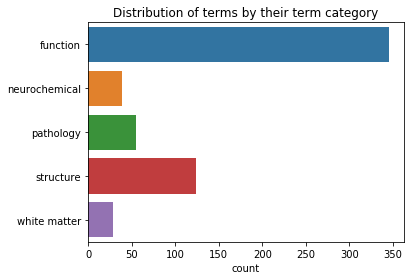

In [8]:
sns.countplot(y=df.drop_duplicates('term').domain)
plt.title('Distribution of terms by their term category')
plt.tight_layout()
plt.ylabel('')
plt.savefig('visuals/terms_dist.png')

Amongst, the terms we based our generation upon a majority of them belonged to the functional category.

In [9]:
outlier_removed_pre = cn_pre[(cn_pre >= 0) & (cn_pre <= 1)]
outlier_removed_post = cn_post[(cn_pre >= 0) & (cn_pre <= 1)]

In [ ]:
cn_df =pd.DataFrame(dict(
    series=np.concatenate(([f"pre-2000 mean:{outlier_removed_pre.mean():0.3f}"]*len(outlier_removed_pre), [f"post-2000 mean:{outlier_removed_post.mean():0.3f}"]*len(outlier_removed_post))), 
    data=np.concatenate((outlier_removed_pre,outlier_removed_post))
))
fig = px.histogram(cn_df,x="data", color="series", 
                   nbins=100, log_y=True,
                   labels=dict(x="Connectivity"),
                   barmode="overlay", title='Connectivity Pre-2000 vs. Post-2000')
fig.update_xaxes(nticks=20, range=[0,1], title_text="Connectivity")
fig.update_yaxes(title_text="Count")

#fig.show()



<img src="https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/visuals/plotly.png?token=AD2SIKMM4AEZNLEZLMJPG6TALWE3S">

The distribution of Jaccard indices in both the pre- and post- 2000 data have a similar fall off as the the index increases. We then see a bin centered at 1 which is of size 591 that is representative of the jaccard index of a term and itself.

#### Connectivity Explorer
Interactive widget to look at the percentage change in connectivity across pre-2000 and post-2000 data

In [109]:
# Instantiate a new MicroLisc object for indexing helpers
importlib.reload(microlisc)
ml = microlisc.MicroLisc(terms=lis)

# Sort terms alphabetically
sorted_terms = sorted(lis, key=lambda x: x[0].lower())

# Event Handler for Button Click
def on_button_clicked(b):
    with output:
        output.clear_output()
        # Fetch Relevant Entry in Connectivity Matrix
        r = ml.term_to_idx[tuple(term1.value)]
        c = ml.term_to_idx[tuple(term2.value)]
        
        # Calculate percent growth across pre- and post-
        change = percentage_change(pre=cn_pre[r][c], post=cn_post[r][c])
        
        # Display.
        output.append_display_data(HTML(f'<h4>Connectivity: {cn_pre[r][c]:0.3e} (Pre) | {cn_post[r][c]:0.3e} (Post) | {change:0.3f}% (Percent Change) </h4>'))


# Generate GUI 
term1 = widgets.Dropdown(
    options=sorted_terms,
    value=sorted_terms[0],
    description='Term 1:',
    disabled=False,
)
term2 = widgets.Dropdown(
    options=sorted_terms,
    value=sorted_terms[1],
    description='Term 2:',
    disabled=False,
)

button = widgets.Button(
    description='Get Connectivity',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Get Data',
    icon='arrow-right' # (FontAwesome names without the `fa-` prefix)
)

output = widgets.Output()

button.on_click(on_button_clicked)
hb = widgets.HBox([term1, term2, button])
widgets.VBox([hb, output])

## Approaches and Methods

### Neighbors of Neighbors connectivity transformation

Our hypothesis generation algorithms rely on jaccard index connectivity, however this only reflects the popularity of terms in the scientific literature. <i>Not</i> the actual relatedness of two terms. And so there is an implicit assumption stating that two terms are related when the scientific literature references them together often. <br>

The <b>neighbors of neighbors tranformation</b> tries to fix this, while still relying on the scientific literature. In essence, it reflects the held belief in distributional semantics that <i>"you shall know a word by the company it keeps."</i><br>

Conceretely, the relatedness of two terms $a$ and $b$ is the jaccard index of the $n$ neighbors most similar to term $a$ and the $n$ neighbors most similar to term $b$. 


Here are the terms most related to memory. Just on inspection, it seems to be recommending better terms than the original connectivity matrix it was based off of.

In [140]:
import neighbors
importlib.reload(neighbors)
from neighbors import NeighborAnalysis

Words with highest connectivity to AIDS from the pre-2000 connecvity matrix

In [179]:
conj_df = pd.read_csv('./new_data/conn_pre.csv', header=None)
conj_df.columns, conj_df.index = df.term.unique(), df.term.unique()
conj_df['memory'].nlargest(10)

memory                 1.000000
learning               0.098232
short term memory      0.056706
working memory         0.049321
amnesia                0.047396
hippocampus            0.046770
dementia               0.035915
long term memory       0.033667
Alzheimer's disease    0.031437
recognition memory     0.030314
Name: memory, dtype: float64

In [180]:
na = NeighborAnalysis()
na.get_related_terms(query='memory')

Most related to memory by category 'function': 
 Index(['Alzheimer's disease', 'amnesia', 'long term memory', 'entorhinal area',
       'short term memory', 'basal forebrain nucleus', 'cognition', 'dementia',
       'dentate gyrus', 'forgetting'],
      dtype='object') 

Most related to memory by category 'neurochemical': 
 Index(['histamine', 'facial nucleus', 'hippocampus', 'learning',
       'somatosensation', 'Alzheimer's disease', 'acetylcholine', 'amnesia',
       'caudate nucleus', 'claustrum'],
      dtype='object') 

Most related to memory by category 'pathology': 
 Index(['declarative memory', 'acetylcholine', 'delayed recognition',
       'fastigial nucleus', 'learning', 'stria terminalis',
       'Alzheimer's disease', 'GABA', 'abstract thinking',
       'attentional capacity'],
      dtype='object') 

Most related to memory by category 'structure': 
 Index(['learning', 'Alzheimer's disease', 'corpus callosum', 'seizure',
       'Huntington's disease', 'alcoholism', 'attent

The results above, indicate the related terms to a source term, in this case AIDS, that share a parent from a specific term category.

/Users/icpc/Desktop/cs/experiments/Projects-W21-text-mining/neighbors.py:62: UserWarning:

This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.



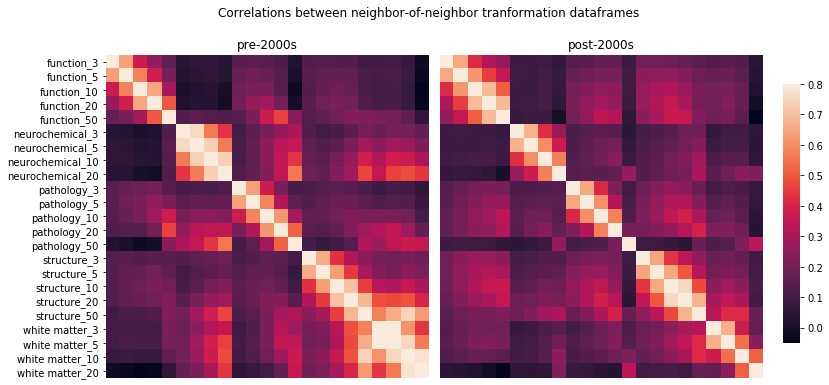

In [141]:
na.generate_heat_maps()

##### Correlation of neighbors-of-neighbors dataframes (hyperparameter search). <br>
We see that datasets within the same term category are most closely correlated with one another, where (within-term category) the correlations highest for the closest number of neighbors analyzed. <br> Suprisingly, the correlations between dataframes are relatively low.

In [ ]:
names_full = [*[names + '_pre' for names in names_before], *[names + '_post' for names in names_after]]
terms_full = [*term_nvals_before, *term_nvals_after]

plt.figure(figsize = (14,10))
sns.heatmap(spearmanr(terms_full, axis=1)[0], square = True, \
            yticklabels=names_full, xticklabels=False, vmax=0.8)
plt.title('Correlations between all neighbor-of-neighbor tranformation dataframes')
plt.tight_layout()
plt.show()

How are the transformed jaccard indices disrtibuted across all transformations?

In [ ]:
fig=plt.figure(figsize=(12,7), constrained_layout=False)
col, row = 3,2
type_index = [list(filter(lambda i: term in names_full[i], range(len(names_full)))) for term in term_types]
for i, term in enumerate(term_types):
    ind = list(filter(lambda j: term in names_full[j], range(len(names_full))))
    corrs = np.asarray(list(itertools.compress(terms_full, ind))).flatten()
    fig.add_subplot(row, col, i+1)
    plt.ticklabel_format(axis="y", style="sci")
    plt.title(f'Jaccard index distribution: {term}')
    sns.distplot(corrs, kde=False)
    plt.xlim(0, 0.5)
plt.tight_layout()


Unfortunately, we did not use the 'neighbor or neighbors' transformation on our hypothesis generation, however we predict that it might lead to more valid hypotheses that does not necessarily depend so heavily on the current scientific literature.

### 'Hypothesis-First' Attractiveness Algorithm

At its core, the hypothesis-first attractiveness algorithm relies on the same principle as Voytek's algorithm: "a friend-of-a-friend should be a friend". <br>

The hypothesis-first algorithm improves on this idea by evaluating "friend of a friend" criterion over all parent terms:

<img src="https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/visuals/neighbors_first.png?token=AD2SIKLVKBYSS2LOWJWYL3TALWEXS" alt="description of algorithm" width = '800'>

The total number of parent terms that strongly relate two terms is the score of "attractiveness" between two terms. If two terms are strongly related to one another, they should share this link for <i>many</i> parent terms. By using this method, we are able to store <i>which</i> parent terms relate the two terms. Moreover, since our terms can be partitioned into 5 term categories (e.g., function), we are also able to analyze <i>in which categories</i> are the terms related. This gives us several advantages: 
- robustness to spurious correlations (popular topics dominating generated hypotheses)
- ordinal - not binary - measurement scale allows us to rank and compare how good the hypotheses are
- comparability across time scales (did the attractiveness go up or down?)
- greater specificity: now that we know this hypothesis is attractive, <i>where</i> should we start looking? We should look for similarities in their parents to find out.

Given three terms, P, H1, and H2, the algorithm employed in the Voytek & Voytek paper recommends terms H1 and H2 as a hypothesis if the following requirements are met:
- There exists a term P which has a conjunction with term H1 of over 1000 papers, and a conjunction with term H2 of over 1000 papers. 
- Terms H1 and H2 have a conjunction of less than 30 papers.



A potential area for improvement of this generation method is its lack of robustness in regards to it being skewed towards popular or commonly used terms in the literature. The hypothesis first model takes a different approach, in order to address this issue. In our model, the threshold that we use to determine a good hypothesis depends on the parent term. For candidate hypothesis terms $h_1$ and $h_2$ and parent term $p$, a triplet is defined as being a good hypothesis when:
- The jaccard index between $p$ and $h_1$ is in the top $n$ percentile of jaccard indices associated with parent $p$. 
- The jaccard index between $p$ and $h_2$ is in the top $n$ percentile of jaccard indices associated with parent $p$. 
- The jaccard index between $h_1$ and $h_2$ is in the bottom $l$ percentile of jaccard indices associated with parent $p$.

The bottom threshold needs to be adjusted to reflect the bottom $l$ percentile of jaccard indices associated with hypothesis $h_1$ or $h_2$, however the current parameters $l$ is tested on (0.4, 0.55) almost always necessitates $h_1$ and $h_2$ to have a jaccard index of 0. The upper threshold parameters are currently (0.95, 0.85), respectively. This gives us a <i>strict</i> and a <i>lax</i> attractiveness measure: 
- $l = 0.40$, $n = 0.95$
- $l = 0.55$, $n = 0.85$

In [176]:
import hfalgo
importlib.reload(hfalgo)
from hfalgo import HypothesisFirst

In [177]:
hf = HypothesisFirst(generate_hypothesis_matrices=True)

/Users/icpc/.pyenv/versions/3.6.5/lib/python3.6/site-packages/seaborn/distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



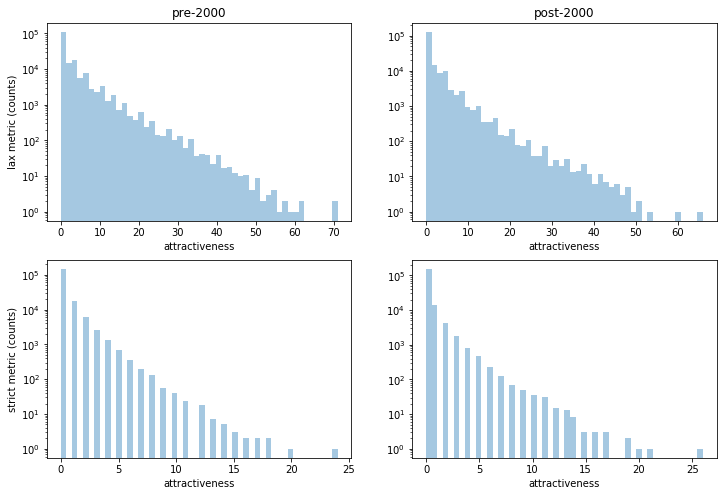

In [157]:
hf.plot_attractiveness_distribution()

Distribution of attractiveness scores of predicted hypotheses for each metric (relaxed and strict)

In [147]:
import Voytek_Algorithm
importlib.reload(Voytek_Algorithm)
from Voytek_Algorithm import Voytek_alg

##### These are the top 10 most attractive hypotheses in the strict and lax algorithms, based on data pre-2000

In [183]:
hf.generate_top_k_hypotheses(k=10, mode='relaxed')

,t1,t2,attractiveness
52117,verbal memory,eye movement,71.0
133254,prefrontal cortex,agnosia,70.0
73805,agnosia,selective attention,62.0
141201,straight gyrus,mammillary body,62.0
58113,working memory,handedness,60.0
52225,verbal memory,object recognition,59.0
98070,anterior cingulate gyrus,language processing,58.0
133201,prefrontal cortex,visual search,58.0
134599,primary motor cortex,long term memory,56.0
133564,premotor cortex,long term memory,54.0


In [184]:
hf.generate_top_k_hypotheses(k=10, mode='strict')

,t1,t2,attractiveness
113974,inferior parietal lobule,broca's area,24.0
39989,set shifting,digit span,20.0
39022,sentence comprehension,picture naming,18.0
148734,temporal pole,middle frontal gyrus,18.0
17687,memory trace,executive function,17.0
144433,superior frontal gyrus,premotor cortex,17.0
126701,parahippocampal gyrus,broca's area,16.0
56033,wisconsin card sorting,divided attention,16.0
38022,semantic processing,crossmodal,15.0
136444,pulvinar,fastigial nucleus,15.0


Are these hypotheses valid? Looking at <i>only</i> the top hypothesis for the two metrics, it appears to be the case. <br>

The best hypothesis for the strict metric is a link between the <b>inferior parietal lobule</b> and <b>broca's area</b>. According the [first result on google](https://thebrain.mcgill.ca/flash/i/i_10/i_10_cr/i_10_cr_lan/i_10_cr_lan.html) when searching up these two terms, it appears to be the case:

> For many years, scientists’ understanding of how the brain processes language was rather simple: they believed that Wernicke’s area interpreted the words that we hear or read, then relayed this information via a dense bundle of fibres to Broca’s area, which generated any words that we spoke in response. But subsequent experiments with brain imaging have revealed the existence of a third region of the brain that is also indispensable for language. <br> <br>
> This region is the inferior parietal lobule, also known as “Geschwind’s territory”, in honour of the American neurologist Norman Geschwind, who foresaw its importance as early as the 1960s. Brain imaging studies have now shown that the inferior parietal lobule (angular gyrus and supramarginal gyrus) is connected by large bundles of nerve fibres to both Broca’s area and Wernicke’s area. Information might therefore travel between these last two areas either directly, via the arcuate fasciculus, or by a second, parallel route that passes through the inferior parietal lobule.

This is supported by Web of Science analytics, which shows that no articles were published (pre-2000, hence the chart starting at 2000) containing these two terms in their title: 

(publications per year)
<img src="https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/visuals/WoS_IPL_Broca.jpg?token=AD2SIKNFQHPCM3Z6ZMLF3ZLALWED6" alt="description of algorithm" width = '800'>
The best hypothesis for the lax metric is a link between the <b>verbal memory</b> and <b>eye movement</b>. According a research article published in 2016 named "[Listen up, eye movements play a role in verbal memory retrieval](https://www.researchgate.net/publication/269820004_Listen_up_eye_movements_play_a_role_in_verbal_memory_retrieval)" when searching up these two terms, it appears to be the case. Here is the Web of Science publication-over-time chart: 

<img src="https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/visuals/WoS_verbalmem_eyemove.jpg?token=AD2SIKOTAACDVP4WMDS73ITALWEKA" alt="description of algorithm" width = '800'>

The following graph demonstrates the ability of the hypothesis first model to find and recommend hypotheses for rarely studied terms. The inferior parietal lobule had only been studied in around 100 papers up to the year 2000. In the following years, the inferior parietal lobule was heavily explored, climbing up to numbers in the thousands of papers. The hypothesis first model  predicted a strong connection between broca’s area and the inferior parietal lobule, which ended up being studied in the post 2000 years.  The model utilized by Voytek and Voytek would have been unable to predict this hypothesis, simply due to the small amount of papers written about the inferior parietal lobule: 

<img src="https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/visuals/wos.png?token=AD2SIKM3FZBSUTDH5Q3WFK3ALWELQ" width='800'>








Although a few papers were published pre-2000, the increase post-2000 is quite significant. There is good evidence that this algorithm is producing fruitful hypotheses.

##### These are the top 10 most attractive hypotheses for the future (post-2020) using the strict and lax algorithms, based on data from 2000-present

In [149]:
lax_pre, lax_post, strict_pre, strict_post = hf.get_hypothesis_matrices()

In [156]:
hf.generate_top_k_hypotheses(k=10, mode='relaxed', lm=lax_post)

,t1,t2,attractiveness
160355,corpus callosum,dorsomedial nucleus of the hypothalamus,66.0
141201,straight gyrus,mammillary body,60.0
136444,pulvinar,fastigial nucleus,53.0
115415,insula,cochlear nuclei,51.0
121764,mesencephalic nucleus of the trigeminal nerve,mammillary body,51.0
153680,ventral posteromedial nucleus,oculomotor nuclear complex,49.0
166714,internal capsule,superior olive,48.0
127746,perirhinal area,mammillary body,48.0
141174,straight gyrus,dorsal motor nucleus of the vagus nerve,48.0
141073,straight gyrus,gaba,48.0


In [154]:
hf.generate_top_k_hypotheses(k=10, mode='strict', sm=strict_post)

,t1,t2,attractiveness
136444,pulvinar,fastigial nucleus,26.0
170092,stria terminalis,abducens nucleus,21.0
153680,ventral posteromedial nucleus,oculomotor nuclear complex,20.0
115894,interstitial nucleus of cajal,claustrum,19.0
141201,straight gyrus,mammillary body,19.0
141174,straight gyrus,dorsal motor nucleus of the vagus nerve,17.0
144935,superior olive,intralaminar nuclear group,17.0
136486,pulvinar,perirhinal area,17.0
118323,mammillary body,gracile nucleus of the medulla,16.0
103270,claustrum,abducens nucleus,16.0


#### Headline from July 2020 mentioning a link between projections from the thalamus (location of pulvinar) and the cerebellum. The top hypothesis for the the strict metric on post-2000 data.

<img src='https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/visuals/fastigial.png?token=AD2SIKKSRXMYOHJLGLZNKCTALWENI'>

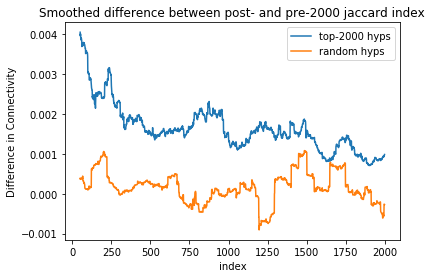

In [165]:
hf.smoothed_jaccard()

It seems that our top hypotheses (blue) where (index 0 is the most attractive) are performing better than a random sample of hypotheses, in terms of the difference in connectivity pre-2000 vs post-2000. This suggests that our top hypotheses are getting studied more than any random hypothesis on average. This serves in some capacity as a validation of the algorithm predicting hypotheses better than chance.

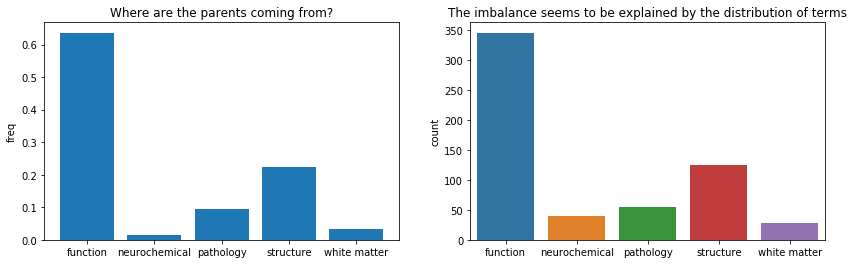

In [172]:
hf.parents()

When a hypotheses gets counted as attractive, what are the parents that it comes from? At first glance, it seems like there's an bias towards functions counting all the hypotheses, however we see that this is not the case. The bias towards functions as parents is explained by the fact most of the terms in our dataset are function terms.

In [178]:
hf.scaled_frequency()

function_counts  neurochemical_counts  \
t1_type       t2_type                                                
function      function              5.336251              0.028333   
neurochemical function              2.006689              7.955293   
pathology     function              4.547491              0.296051   
              neurochemical         1.280193             14.850427   
              pathology             2.989130              1.522436   
structure     function              3.594164              0.387260   
              neurochemical         0.597456             12.663527   
              pathology             2.536497              2.780126   
              structure             0.620088              0.187099   
white matter  function              2.888780              0.403342   
              neurochemical         0.386473             19.871795   
              pathology             1.618357              1.709402   
              structure             0.482629              0.208563   
              white matter          0.386473              0.000000   

                             pathology_counts  structure_counts  \
t1_type       t2_type                                             
function      function               2.776941          0.885166   
neurochemical function              12.214452          1.013234   
pathology     function               6.589575          0.910612   
              neurochemical         13.106061          0.772849   
              pathology             14.090909          0.151210   
structure     function               2.817396          5.106454   
              neurochemical          2.226345          7.916392   
              pathology              6.973027          4.649651   
              structure              0.455299         15.603434   
white matter  function               5.372829          4.494382   
              neurochemical          4.090909          5.645161   
              pathology              8.863636          3.360215   
              structure              0.843845         12.590678   
              white matter           0.606061          8.064516   

                             white matter_counts  
t1_type       t2_type                             
function      function                  0.269666  
neurochemical function                  0.824176  
pathology     function                  0.461280  
              neurochemical             1.041667  
              pathology                 0.111607  
structure     function                  2.131451  
              neurochemical             5.758017  
              pathology                 5.729984  
              structure                 7.255390  
white matter  function                  4.614767  
              neurochemical             4.464286  
              pathology                16.369048  
              structure                16.131237  
              white matter             23.809524

And so when we scale by term category frequency, we see something interesting. The parents of a hypothesis are mainly of the same term category as the hypotheses themselves. 

Overall, there is still a lot of work to be done on the hypothesis first algorithm (e.g. implementing it on the neighbors-of-neighbors data) however it does seem to be a promising approach to hypothesis discovery.

## Results

### Hypothesis Generation Tool

In [38]:
# Sort terms alphabetically
search_terms = [i for i in df.term.unique()]
sorted_terms = sorted(search_terms, key=lambda x: x[0].lower())

In [76]:
# Generate GUI 
hyp_term = widgets.Dropdown(
    options=sorted_terms,
    value=sorted_terms[0],
    description='Search Term:',
    disabled=False,
)

hyp_button = widgets.Button(
    description='View Hypotheses',
    disabled=False,
    button_style='info',
    tooltip='Get Data',
    icon='arrow-right'
)
       

output_hyp = widgets.Output()
output_hyp1 = widgets.Output()

from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)
    
# Event Handler for Button Click
def on_button_clicked(b):
    with output_hyp:
        output_hyp.clear_output()
        display(hf.generate_top_k_hypotheses(k=10, mode='relaxed', term=hyp_term.value))
    with output_hyp1:
        output_hyp1.clear_output()
        display(va.show_hypothesis(hyp_term.value).iloc[:10])



hyp_button.on_click(on_button_clicked)
hyp_box = widgets.HBox([hyp_term, hyp_button])

table1_box = widgets.VBox([widgets.Text('Hypothesis-First Algorithm'),output_hyp])
table2_box = widgets.VBox([widgets.Text('Voytek\'s Algorithm'), output_hyp1])

table_box = widgets.HBox([table1_box , table2_box])

widgets.VBox([hyp_box, widgets.HBox([]), table_box])

## Analysis

<img src="https://raw.githubusercontent.com/NeuralDataScience/Projects-W21-text-mining/main/accuracyplot.png?token=AD2SIKMB6OCGVMQCHPS5ORTALWEVC">

The performance of both models is difficult to properly convey given the sheer scope of true negatives, i.e. term combinations that experienced no growth in the pre to post 2000 period. This is because it is significantly more likely for a term pair to not see any growth than for a term pair to explode in occurrence. Hence, when visualizing the performance of the model it is only relevant to compare the rate of true positives and false positives. We can visualize this in a side by side bar chart, contrasting the performance of the original Voytek model and the new Attractiveness model.  

To evaluate what constitutes a true positive vs a false positive we use the distribution of percentage value increase/decrease seen in term co occurrence in the pre to post 2000s. Anything above a standard deviation of zero in percentage increase constitutes a “positive”. In our dataset 20% of term pairs are above a standard deviation of zero, with the remaining 80% falling below the threshold and being designated a “negative”.


The contrast between the Voytek model and the Attractiveness model is significant in two major ways. Primarily we can see a stark contrast between the number of true positives within the model, with the attractiveness model producing many more plausible hypotheses. Additionally, we can see that the Attractiveness model also predicts a greater number of hypotheses that experienced insignificant growth over the pre to post 2000s period. Despite this, the ratio of true positives to false positives is significantly more favorable for the Attractiveness model, suggesting that a randomly selected term pair recommended by the model has a greater chance of experiencing occurrence growth in the post-2000 period. 


## Discussion and Further Directions
Based on the approaches implemented so far and the success we have seen, there is a range of different directions we could choose to further develop our architecture for automated hypothesis generation.

**A more descriptive dataset:**
Currently our architecture is limited by the scope of terms we are investigating and the data we are capturing related to those terms. To be specific the current architecture leans heavily on the scraped term-pair counts of just PubMed published literature. Whilst this is sufficient as a proof of concept, it isn’t comprehensive and there are many ways we can further develop this stage of the project. One idea was to explore the citations of the papers we are scraping and the h-index of the authors publishing said papers. Based on how the current architecture works, terms can co occur frequently in a range of papers, however, these papers can be largely insignificant, rarely being cited or reviewed. By utilizing the citations of each paper and how citations are growing over time we can add an extra dimension of scrutiny to our produced hypotheses, potentially boosting the utility of the output.

**Addition of NLP to add extra insight into scraped hypotheses:**
One proposed area for further investigation is the addition of NLP driven insights into the data collection process. Currently the models derive insight from data relating to term occurrence, however, the addition of sentiment analysis could help add a level of scrutiny to the number and type of occurring matches. This is because simply capturing term occurrence fails to account for how the terms are occurring together, for example, “Alzheimer's disease is related to the deterioration of the prefrontal cortex” does not share equivalence to “Alzheimer's disease has no relation to the deterioration of the prefrontal cortex”. Through building the functionality for the architecture to understand these relationships, the models would be able to make better decisions relating to the hypothesis it produces.

**Construction of a research tool:**
Following the testing and finalization of the hypothesis generation framework, the team is interested in developing a Python Package Index API for public use. This API would function as a streamlined way for prospective researchers to query for hypotheses based on our refined models, allowing for deployment in the wider scientific community. 


## Conclusion
Our goal was to improve upon the hypothesis generation methods presented in the 2012 Voytek & Voytek paper, in order to identify and rank candidate hypotheses accurately and then to validate them by their characteristics (particularly co-occurrence data) in future time periods. The favorable true positive ratio for the Attractiveness model is indicative of a greater number of plausible hypotheses being generated by the Attractiveness model than by the Voytek model. In other words,  a randomly selected  term pair recommended by the Attractiveness model- therefore, based on the number of parent terms that strongly relate two terms- has a greater chance of experiencing occurrence growth in the post-2000 period. These results support the promise of implementing a hypothesis generation tool that utilizes novel metrics and measures of association between topics to suggest viable, cutting-edge areas of research. Prominent areas for future exploration that we believe will be useful in such a task are gathering and extracting more descriptive data, such as author information, h-index, and various context-specific features, as well as the application of sentiment analysis and other natural language processing (NLP)  tools for producing more meaningful relationships and representations from the data. 


### References
1. Jessica B Voytek, Bradley Voytek | *Automated cognome construction and semi-automated hypothesis generation* (2012)
2. Wilson, et al.  | *Automated literature mining and hypothesis generation through a network of Medical Subject Headings* (2018)
3. Sybrandt, et al. | *MOLIERE: Automatic Biomedical Hypothesis Generation System* (2017)
4. Sybrandt, et al. | *AGATHA: Automatic Graph-mining And Transformer based Hypothesis generation Approach* (2020)